# 필요 라이브러리 불러오기

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import random, os
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
from sklearn.metrics import roc_curve, roc_auc_score, auc
import optuna
from imblearn.over_sampling import SMOTENC
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.drop(columns='id', inplace=True)
df_test.drop(columns='id', inplace=True)

# 시드 고정

In [4]:
# fix seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

# 데이터 전처리

In [21]:
df_train = df_train[df_train['person_emp_length'] <= 100]

In [26]:
def onehotenc(df):
    df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], drop_first=True)
    return df

def bool2int(df):
    df[df.select_dtypes(include=['bool']).columns] = df.select_dtypes(include=['bool']).astype('int64')
    return df

scaler = StandardScaler()

# 모델 개발

In [27]:
# train 데이터를 train과 valid 데이터로 분할
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("loan_status", axis=1),
    df_train["loan_status"],
    test_size=0.2, # 비율 train : valid = 8 : 2
    shuffle=True, # 데이터의 class가 편중되는 것을 방지 
    random_state=SEED,
    stratify = df_train["loan_status"] # train/valid 데이터의 class 비율을 동일하게
)

## 훈련 및 검증 데이터 전처리 적용

In [28]:
x_train = onehotenc(x_train)
x_val = onehotenc(x_val)

In [29]:
x_train = bool2int(x_train)
x_val = bool2int(x_val)

In [30]:
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.fit_transform(x_val)

x_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_val = pd.DataFrame(x_val_scaled, columns=x_val.columns)

In [31]:
y_train = y_train.reset_index(drop=True)
x_train = x_train.reset_index(drop=True)

## 모델 훈련

In [32]:
# 로지스틱 회귀 모델 훈련
reg_model = LogisticRegression()
result = reg_model.fit(x_train, y_train)

In [33]:
# p-value 값 출력을 위한 statsmodel 훈련
logit_model = sm.Logit(y_train, x_train)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 9


c:\users\it\appdata\local\programs\python\python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\users\it\appdata\local\programs\python\python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


## p-value, 회귀 계수 출력

In [13]:
features_of_interest = ['loan_percent_income', 'person_income', 'loan_amnt', 'loan_int_rate']
coefficients = result.params
p_values = result.pvalues

df = pd.DataFrame({
    'Feature': features_of_interest,
    'Coefficient': [coefficients[x_train.columns.get_loc(feature)] for feature in features_of_interest],
    'P-value': [p_values[x_train.columns.get_loc(feature)] for feature in features_of_interest]
})
df['Significance'] = ['Significant' if p < 0.05 else 'Not Significant' for p in df['P-value']]
df

,Feature,Coefficient,P-value,Significance
0,loan_percent_income,0.882899,0.000000e+00,Significant
1,person_income,0.123881,1.796061e-13,Significant
2,loan_amnt,-0.404084,1.095189e-79,Significant
3,loan_int_rate,0.093025,1.459535e-02,Significant


## 모델 성능 평가

In [15]:
y_pred = reg_model.predict(x_val)

print("roc auc score (LosigticRegression):", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

roc auc score (LosigticRegression): 0.7520960167347976
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10059
           1       0.77      0.53      0.63      1670

    accuracy                           0.91     11729
   macro avg       0.85      0.75      0.79     11729
weighted avg       0.90      0.91      0.90     11729



c:\users\it\appdata\local\programs\python\python38\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


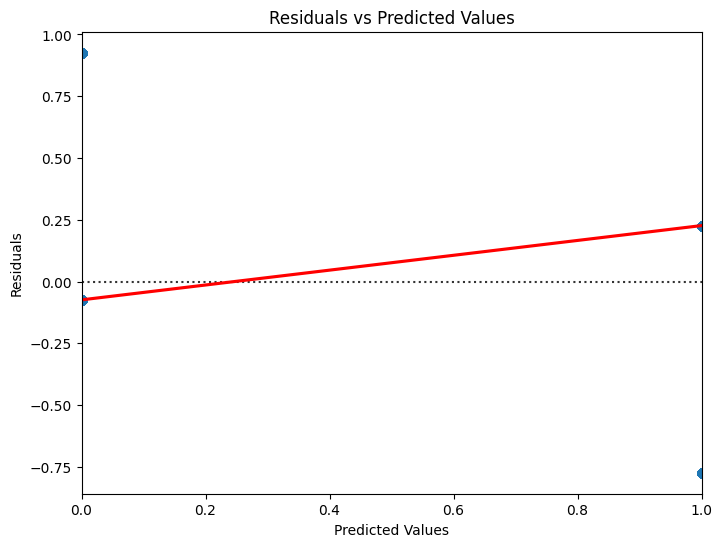

In [16]:
residuals = y_val - y_pred

# 잔차 플롯 시각화
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

In [19]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc_score = auc(fpr, tpr)
auc_score

0.7520960167347976

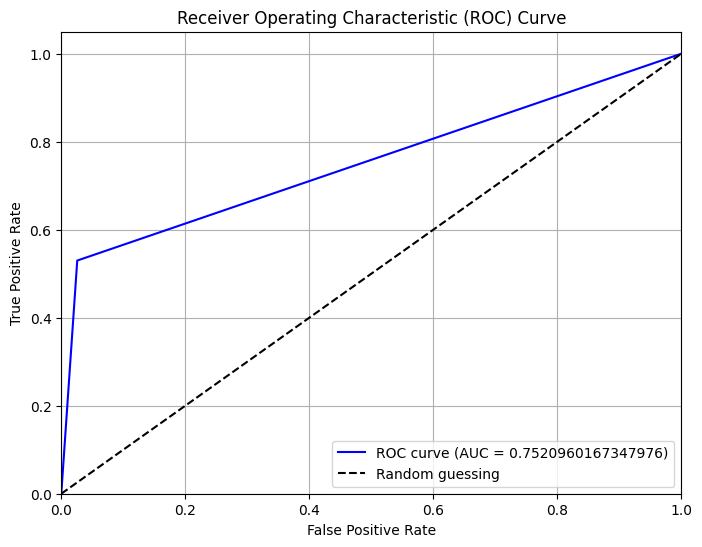

In [20]:
# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()